KeyboardInterrupt: 

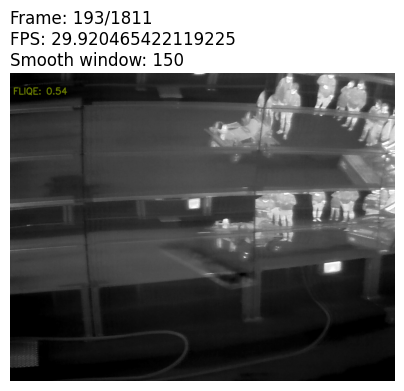

In [8]:
import cv2
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
import sys, os
sys.path.append(os.path.abspath('../src'))
from fliqe import OnlineFLIQE
from fliqe.distortions import *


fliqe = OnlineFLIQE(quality_model_path="../models/encoder_with_binary_head.pth", smoothing_window=150)
fliqe.create_session('testing_video')
cap = cv2.VideoCapture("../data/9.MP4")
cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
processed_frames = 0

# --- Set up video writer ---
output_path = "output_video.mp4"
fps = cap.get(cv2.CAP_PROP_FPS)
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
print(f"Video size: {frame_width}x{frame_height}, FPS: {fps}, Smoothing window: {fliqe.smoothing_window}")

fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # or 'XVID' for .avi
out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Compute FLIQE score
    _ = fliqe.estimate_smoothed_quality(frame, session_id='testing_video')
    processed_frames += 1

    print(f"Processed frame {processed_frames}/{frame_count}", end="\r" )

    # Annotate frame
    annotated = frame.copy()
    color = fliqe.get_color(fliqe.get_smoothed_quality('testing_video'))
    cv2.putText(
        annotated, f"FLIQE: {fliqe.get_smoothed_quality('testing_video'):.2f}", (10, 70),
        cv2.FONT_HERSHEY_SIMPLEX, 1.0, color, 2, cv2.LINE_AA
    )

    # --- Save frame to video ---
    out.write(annotated)

    # Optional: still show in notebook
    rgb = cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB)
    clear_output(wait=True)
    plt.figure(figsize=(6,4))
    plt.imshow(rgb)
    plt.axis('off')
    plt.title(f"Frame: {processed_frames}/{frame_count}\nFPS: {fps}\nSmooth window: {fliqe.smoothing_window}", loc='left')
    display(plt.gcf())
    plt.close()

# --- Cleanup ---
cap.release()
out.release()
print(f"✅ Video saved as {output_path}")